# Исследование объявлений о продаже квартир

В вашем распоряжении архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**В процессе исследования мы:**  
- Ознакомимся с данными
- Сделаем предобработку данных - постараемся заполнить пропуски и избавиться от аномальных значений
- Добавим в таблицу новые столбцы, необходимые для более подробного исследования
- Изучим данные:
 - Посмотрим квартиры с какими параметрами чаще всего продаются
 - Определим средний срок для продажи квартиры
 - Посмотрим корреляцию цены объектов и некоторых их параметров
 
**Цель исследования:**  
Определить параметры, больше всего влияющие на стоимость квартир.  
 

### Изучение общей информации. 

In [1]:
#импортируем необходимые для исследования библиотеки
import pandas as pd
import matplotlib.pyplot as plt
#прочитаем файл и взглянем на общую информацию, а также первые пять строк датасета
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
display(data.info())
display('Количество дубликатов:', data.duplicated().sum())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

None

'Количество дубликатов:'

0

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [2]:
#Приведем название столбца cityCentres_nearest к змеиному регистру
data = data.rename(columns={'cityCenters_nearest': 'city_center_nearest'})

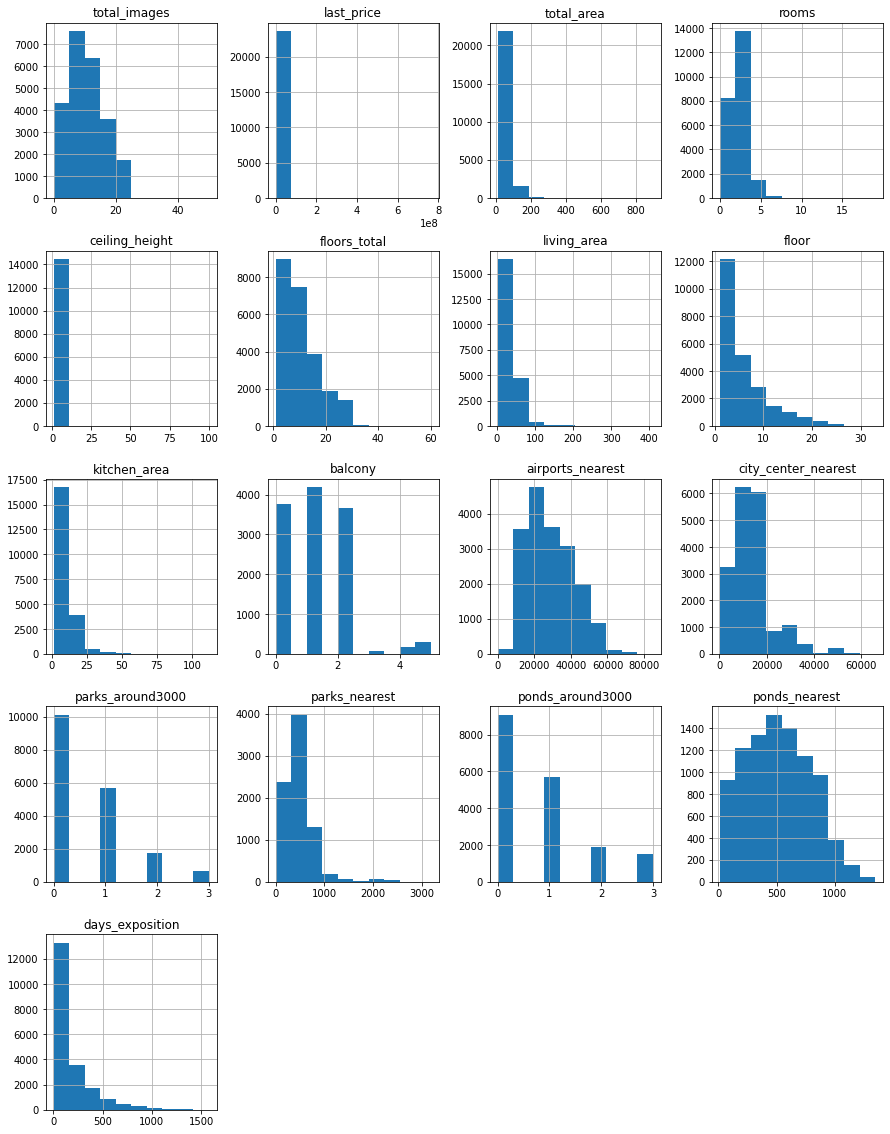

In [3]:
#Посторим общую гистограмму для всех столбцов таблицы
data.hist(figsize=(15, 20));

**Выводы:**  
Всего в датасете 23699 строк, 22 столбца.  
Достаточно много пропусков в различных стоблцах.  
Явных дубликатов не обнаружено. Значения в некоторых столбцах находятся в неудобных для исследования форматах.  
Название одного из столбцов стилистически неверное

### Предобработка данных.

 ***Какие выводы можно сделать, глядя на общую информацию о датасете?***  
Всего 23699 объявления, 21 столбец с параметрами.

Несоответствие столбцов типу данных:  
**parks_around3000**; **ponds_around3000**; **floors_total**; **balcony**; **days_exposition**; **rooms**, **last_price**  - должен быть тип int64 - так как в этих столбцах предполагаются значения в целых числах  
**first_day_exposition** - должен быть типа datetime64, так как указывается дата  
**is_apartment** - должен быть тип bool, так как подразумевается только два значения - апартаменты это или нет  


**Пропуски или нулевые значения** есть во всех столбцах, кроме:  
total_images, last_price, total_area, first_day_exposition, rooms, floor, studio, open_plan 


**Исследование и заполнение пропусков в данных**

In [4]:
#Посмотрим суммарное количество пропусков в каждом из столбцов
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_center_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

**О причинах пропусков:**    
Пропуски могут возникать по разным причинам. Возможно система сбора информации дала сбой.
Какие-то вопросы остаются при заполнении объявления без ответа - как например наличие балкона. Отвечая на подобные вопрос, люди часто подразумевают, что отсутствие ответа = отрицательный ответ.

Какие-то вопросы в анкете могут появляться уже после того, как идёт сбор информации. Так, например, можно предположить, что вопрос об апартаментах появился недавно - подавляющее число объявлений не содержат ответ на этот вопрос

In [5]:
#Заполним пропуски в столбцах, где это возможно:

#Логично предположить, что если число балконов не указано, то их нет
data['balcony'] = data['balcony'].fillna(0) 
#Если не указано, что квартира является апартаментами, то признаем, что она ими не является
data['is_apartment'] = data['is_apartment'].fillna(False) 
#Если не указано количество близкорасположенных парков и прудов, то скорее всего, рядом их нет. Меняем пропущенные значения на 0
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
#Пропущенных значений в столбце с названием населенного пункта не так много, их можно заменить на Unknown
data['locality_name'] = data['locality_name'].fillna('unknown')

#Пропуски в столбцах living_area и kitchen_area нельзя нельзя заполнить средними значениями этих столбцов,
#так как они находятся в корреляции со значениями из стоблца total_area.
#Найдем среднее отношение жилой площади и площади кухни к общей площади квартиры
#заменим пропущенные значения числом, полученным умноженим площади квартиры на это среднее отношение
living_area_ratio = data['living_area'].mean() / data['total_area'].mean()
kitchen_area_ratio = data['kitchen_area'].mean() / data['total_area'].mean()
data['living_area'] = data['living_area'].fillna(living_area_ratio * data['total_area'])
data['kitchen_area'] = data['kitchen_area'].fillna(kitchen_area_ratio * data['total_area'])


#Взаимосвязи между пропусками в столбцах floors_total обнаружить не удалось.
#В то же время заменить пропуски медианными или средними значениями будет некорректно.
#Принято решение удалить из датасета эти строки
data.dropna(subset=['floors_total'], inplace=True)


В датасете остались пропущенными значения в столбцах с картографическими данными, а также в столбце с данными по количеству дней размещения объявления.

**Обработка неявных дубликатов**

In [6]:
#Изучаем уникальные значения в столбце с названиями населенных пунктов, меняем все различные наименования поселков
data['locality_name'].unique()
data['locality_name'] = data['locality_name'].str.replace('посёлок', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('городской поселок', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('коттеджный поселок', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('поселок станции', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('поселок при железнодорожной станции', 'поселок')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23613 non-null  int64  
 1   last_price            23613 non-null  float64
 2   total_area            23613 non-null  float64
 3   first_day_exposition  23613 non-null  object 
 4   rooms                 23613 non-null  int64  
 5   ceiling_height        14495 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           23613 non-null  float64
 8   floor                 23613 non-null  int64  
 9   is_apartment          23613 non-null  bool   
 10  studio                23613 non-null  bool   
 11  open_plan             23613 non-null  bool   
 12  kitchen_area          23613 non-null  float64
 13  balcony               23613 non-null  float64
 14  locality_name         23613 non-null  object 
 15  airports_nearest   

In [8]:
#Пропуски в столбце с высотой потолков заменим медианным значением высоты потолков в зависимости от населенного пункта. 
for locality_name in data['locality_name'].unique():
    median = data.loc[data['locality_name'] == locality_name, 'ceiling_height'].median()
    data.loc[(data['ceiling_height'].isna()) & (data['locality_name'] == locality_name), 'ceiling_height'] = median

data.loc[data['ceiling_height'].isna(), 'ceiling_height'] = data['ceiling_height'].median()

/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/p

**Обработка и удаление аномалий (редких значений)**

In [9]:
#Находим и устраняем редкие и выбивающиеся значения
data['ceiling_height'].sort_values(ascending=False)
data.query('ceiling_height > 20 * 0.1')
#Высота потолка выше двадцати метров - сомнительно. Скорее всего это высота не в метрах, а в дециметрах, поэтому поделим её на 10

data['last_price'].describe()
data['last_price'].sort_values().head(50)
#В процессе обнаружены дубликаты - объявления со стоимостью квартиры = 3.2. Удаляем эти объявления,
#а также объявление со стоимостью квартиры в 12900 рублей. Также, выявлены значения за пределами интерквартильного размаха
data = data.loc[data['last_price'] > 13000]

data['total_area'].describe() #выявлены значения за пределами интерквартильного размаха

data['rooms'].describe() #193 нуля - соотнеся эти нули с жилой площадью, указанной в объявлениях, приходим к выводу,
#что будет корректно заменить нули на единицы - жилая площадь у большинства объявлений около 20 кв.м.
data.loc[data['rooms'] == 0]['living_area']
data['rooms'] = data['rooms'].replace(0, 1)  

data['floors_total'].describe() #В этом столбце есть значения больше 35 этажей. Таких многоэтажных домов в Петербурге нет
#удалим из датасета строки с такими объявлениями
data = data.loc[data['floors_total'] < 36]
data['living_area'].describe() #выявлены значения за пределами интерквартильного размаха.
#несколько квартир обладают жилой площадью  меньше 8 квадратных метров.
#Удалим их как нерелевантные
data = data.loc[data['living_area'] > 8]

data['floor'].describe() #аномалий не выявлено
data['is_apartment'].describe() #аномалий не выявлено
data['studio'].describe() #аномалий не выявлено
data['open_plan'].describe() #аномалий не выявлено
data['kitchen_area'].describe() #выявлены значения за пределами интерквартильного размаха.
data['days_exposition'].describe()  #выявлены значения за пределами интерквартильного размаха.
data['balcony'].describe() #аномалий не выявлено
data['parks_around3000'].describe() #аномалий не выявлено
data['ponds_around3000'].describe() #аномалий не выявлено

#Для удаления значений, находящихся за пределами интерквартильного размаха, создадим функцию:
def quartile_range(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    dfq = df.loc[(df[column] < q3 + 1.5*iqr) & (df[column] > q1 - 1.5*iqr), column]
    return dfq
#Список со столбцами, где естьtotal_area выбросы:
wrong_list = ['last_price', 'total_area', 'kitchen_area', 'living_area', 'days_exposition'] 

for col in wrong_list:
    data[col] = quartile_range(data, col)
#И удалим необходимые строки
data.dropna(subset=['last_price'], inplace=True)
data.dropna(subset=['total_area'], inplace=True)
data.dropna(subset=['living_area'], inplace=True)
data.dropna(subset=['kitchen_area'], inplace=True)

Достаточно много пропусков находится в столбцах с картографическими данными. Была идея заменить эти значения медианными в зависимости от локации, но к сожалению, многие объявления, в которых не указано расстояние до центра города или до аэропорта являются единственными в своих населенных пунктах и менять значения просто не на что. Решено оставить пропущенные значения.


**Изменение типов данных**

In [10]:
#Поменяем тип данных в столбцах, где это необходимо. 
data['last_price'] = data['last_price'].astype('int')
data['balcony'] = data['balcony'].astype('int')
data['floors_total'] = data['floors_total'].astype('int')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')
data['parks_around3000'] = data['parks_around3000'].astype(int)
data['ponds_around3000'] = data['ponds_around3000'].astype(int)
data['rooms'] = data['rooms'].astype('int')



In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20898 entries, 1 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20898 non-null  int64         
 1   last_price            20898 non-null  int64         
 2   total_area            20898 non-null  float64       
 3   first_day_exposition  20898 non-null  datetime64[ns]
 4   rooms                 20898 non-null  int64         
 5   ceiling_height        20898 non-null  float64       
 6   floors_total          20898 non-null  int64         
 7   living_area           20898 non-null  float64       
 8   floor                 20898 non-null  int64         
 9   is_apartment          20898 non-null  bool          
 10  studio                20898 non-null  bool          
 11  open_plan             20898 non-null  bool          
 12  kitchen_area          20898 non-null  float64       
 13  balcony         

**Почему нужно менять тип данных?**  

Целочисленный тип данных более удобен для вычислений и сравнений, нежели тип float.  

Булевы значения необходимы для построения логических выражений в дальнейшем

**Выводы:**
В процессе предобработки данных были изменены типы данных в некоторых стоблцах.  
Заполнены пропуски там, где это показалось возможным.  
В столбце с названием населенного пункта обнаружены и исправлены неявные дубликаты. Также дубликаты обнаружены благодаря проверке стоблца, в котором указана стоимость квартиры.  

Для более точного исследования из датасета удалены строки, значения в столбцах которых находятся за пределами интерквартильного размаха.

### Добавление в таблицу новых столбцов.

In [12]:
# Добавляем столбец со стоимостью квадратного метра (sqm_price) и приводим его в целочисленный тип
data['sqm_price'] = data['last_price'] / data['total_area']
data['sqm_price'] = data['sqm_price'].astype(int)

# Добавляем столбцы для определения дня, месяца и года публикации объявления
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

# Создаем функцию для разбивки этажа квартиры по категориям (первый, последний, другой) и применяем её к новому столбцу датасета
def floor_group(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_type'] = data.apply(floor_group, axis=1)

# Создаем столбец с расстоянием до центра в километрах (делим расстояние в метрах на тысячу и округляем до целого числа)
data['city_center_nearest_km'] = data['city_center_nearest'] / 1000
data['city_center_nearest_km'] = data['city_center_nearest_km'].round()


**Вывод:**
На третьем этапе исследования в датасет добавлены новые столбцы - стоимость квадратного метра; день, месяц и год публикации; тип этажа квартиры; расстояние до центра в километрах

### Исследовательский анализ данных.

**Исследование параметров объектов: общей площади, жилой площади, площади кухни, цены, количества комнат и т.д.**

count    20898.000000
mean        52.149513
std         17.344186
min         12.000000
25%         38.800000
50%         48.300000
75%         62.400000
max        114.300000
Name: total_area, dtype: float64

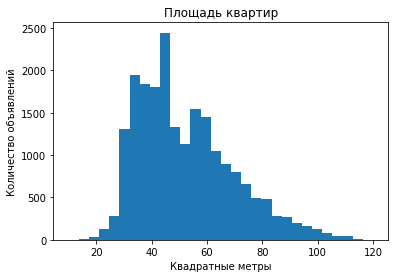

In [13]:
#Изучаем параметр "Общая площадь"
display(data['total_area'].describe())
plt.hist(data['total_area'], bins=30, range=(10,120))
plt.title('Площадь квартир')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество объявлений')
plt.show()



Средняя площадь квартир около 52 квадратных метров. Медианное значение - 48 кв.м.

count    20898.000000
mean        30.045657
std         12.379465
min          8.300000
25%         18.300000
50%         29.000000
75%         38.700000
max         76.800000
Name: living_area, dtype: float64

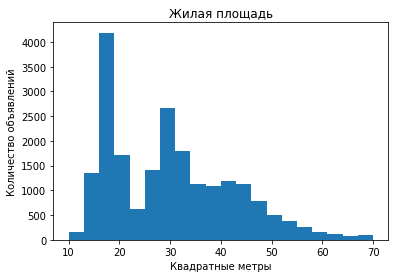

In [14]:
#Изучаем параметр "Жилая площадь"
display(data['living_area'].describe())
plt.hist(data['living_area'], bins=20, range=(10,70))
plt.title('Жилая площадь')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество объявлений')
plt.show()

Жилая площадь в объявлениях имеет два пика - очевидно, они соответствуют средней жилой площади в однокомнатных и двухкомнатных квартирах. В среднем жилая площадь составляет около 30 кв.м.

count    20898.000000
mean         9.119030
std          2.946428
min          1.300000
25%          7.000000
50%          8.700000
75%         10.900000
max         19.420000
Name: kitchen_area, dtype: float64

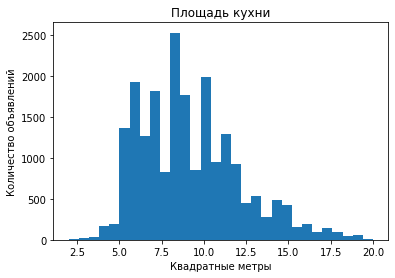

In [15]:
#Изучаем параметр "Площадь кухни"
display(data['kitchen_area'].describe())
plt.hist(data['kitchen_area'], bins=30, range=(2,20))
plt.title('Площадь кухни')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество объявлений')
plt.show()

Средняя кухня в объявлениях - около 10 квадратных метров. Но есть и квартиры с большими кухнями

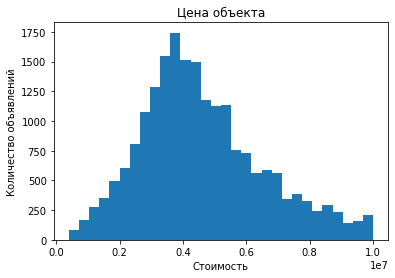

In [16]:
#Изучаем параметры "Цена объекта" 
plt.hist(data['last_price'], bins=30, range=(400000,10000000))
plt.title('Цена объекта')
plt.xlabel('Стоимость')
plt.ylabel('Количество объявлений')
plt.show()

Средняя стоимость квартиры в датасете - около 4,7 млн. руб.

'Распределение объявления по числу комнат:'

1    8057
2    7355
3    4758
4     664
5      61
6       3
Name: rooms, dtype: int64

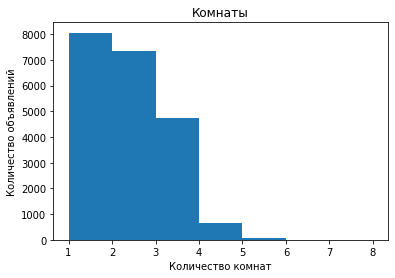

In [17]:
# Изучаем параметр "Количество комнат"
display('Распределение объявления по числу комнат:')
display(data['rooms'].value_counts(ascending=False).head(10))
plt.hist(data['rooms'], bins=7, range=(1,8))
plt.title('Комнаты')
plt.xlabel('Количество комнат')
plt.ylabel('Количество объявлений')
plt.show()

Большинство квартир, прогнозируемо, однокомнатные, двукомантные или трехкомнатные

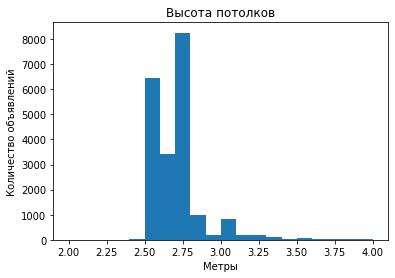

In [18]:
# Изучаем параметр "высота потолков"
plt.hist(data['ceiling_height'], bins=20, range=(2 ,4))
plt.title('Высота потолков')
plt.xlabel('Метры')
plt.ylabel('Количество объявлений')
plt.show()

Высота потолков в большинстве объявлений - стандартные 2.7 метра. Есть и небольшое количество квартир с нестандартно высокими потолками - выше трех метров 

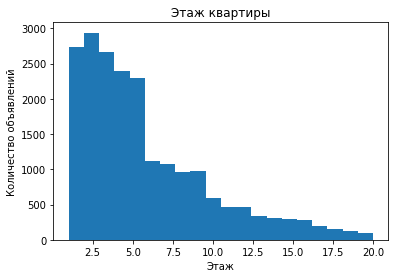

In [19]:
# Изучаем параметр "этаж квартиры"
plt.hist(data['floor'], bins=20, range=(1 ,20))
plt.title('Этаж квартиры')
plt.xlabel('Этаж')
plt.ylabel('Количество объявлений')
plt.show()

Больше всего квартир на 2 этаже. Количество объявлений о квартирах на 1, 3, 4 и 5 этажах отличается незначительно (это можно разглядеть подробнее, если изменить ранжирование гистограммы). В дальнейшем, чем выше этаж, тем меньше есть предложений с данным этажом. На гистограмме видны два пика снижения количества объявлений - после 5 и после 9 этажа, очевидно это связано с особенностями типовой застройки - пятиэтажных и девятиэтажных домов в России больше всего

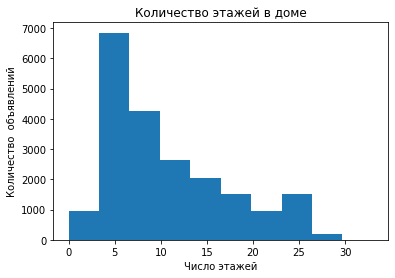

In [20]:
# Изучаем параметр "количество этажей в доме"
plt.hist(data['floors_total'], bins=10, range=(0 , 33))
plt.title('Количество этажей в доме')
plt.xlabel('Число этажей')
plt.ylabel('Количество  объявлений')
plt.show()

Больше всего объявлений, в которых продаются квартиры в пяти- и девятиэтажных домах - типовая застройка. Есть и достаточно количество более высоких домов - скорее всего это новостройки

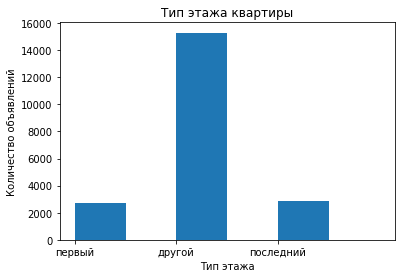

In [21]:
# Изучаем параметр "тип этажа квартиры"
plt.hist(data['floor_type'], bins=6, range=(0 , 3))
plt.title('Тип этажа квартиры')
plt.xlabel('Тип этажа')
plt.ylabel('Количество объявлений')
plt.show()

Большинство продаваемых квартир находятся ни на первом ни на последнем этажах. Количество объявлений о квартирах на первом этаже немногим меньше, чем о квартирах на последнем

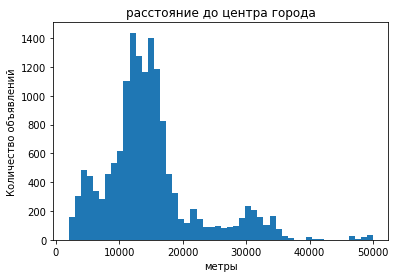

In [22]:
# Изучаем параметр "расстояние до центра города в метрах"
plt.hist(data['city_center_nearest'], bins=50, range=(2000,50000))
plt.title('расстояние до центра города')
plt.xlabel('метры')
plt.ylabel('Количество объявлений')
plt.show()

Большая часть квартир продается в спальных районах Санкт-Петербурга - расстояние до центра города от 12 до 18 километров.
Также есть два пика в пригородах - расстояние около 22км и 30 км, вероятно это крупные города в ЛенОбласти

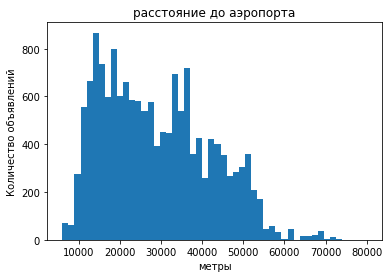

In [23]:
# Изучаем параметр "расстояние до ближайшего аэропорта"
plt.hist(data['airports_nearest'], bins=50, range=(6000,80000))
plt.title('расстояние до аэропорта')
plt.xlabel('метры')
plt.ylabel('Количество объявлений')
plt.show()

Аэропорт в Петербурге один - Пулково. Количество объявлений в непосредственной близости невелико - меньше 100 объявлений на расстоянии около 6-7 километров.

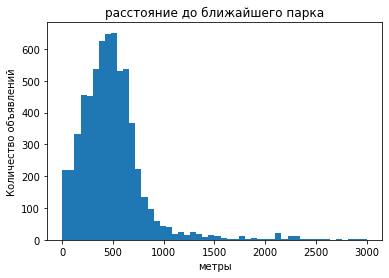

In [24]:
# Изучаем параметр "расстояние до ближайшего парка"
plt.hist(data['parks_nearest'], bins=50, range=(1,3000))
plt.title('расстояние до ближайшего парка')
plt.xlabel('метры')
plt.ylabel('Количество объявлений')
plt.show()

С парками в Петербурге получше, чем с аэропортами. Большая часть объявлений с парком в пешей доступности

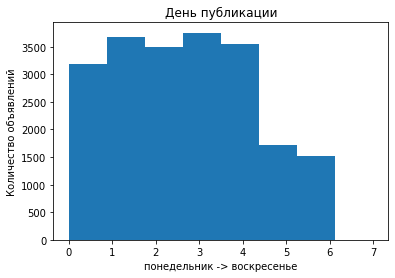

In [25]:
# Изучаем параметр "День публикации объявления"
plt.hist(data['weekday'], bins=8, range=(0,7))
plt.title('День публикации')
plt.xlabel('понедельник -> воскресенье')
plt.ylabel('Количество объявлений')
plt.show()

Чаще всего объявления подаются во вторник в четверг. Значительно реже - на выходных

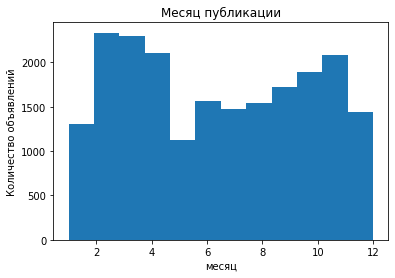

In [26]:
# Изучаем параметр "Месяц публикации объявления"
plt.hist(data['month'], bins=12, range=(1,12))
plt.title('Месяц публикации')
plt.xlabel('месяц')
plt.ylabel('Количество объявлений')
plt.show()

Больше всего объявлений подано в феврале и это при том, что в этом месяце меньше дней, чем в остальных. Меньше всего объявлений в мае и январе, слишком много выходных. Осенью количество объявлений увеличивается, а в декабре их снова мало.

**Исследование количества дней для продажи квартиры**

Время продажи (среднее): 125 дней 

Время продажи (медиана): 80 дней



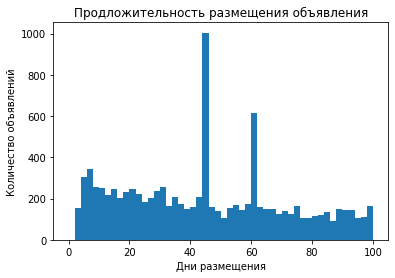

In [27]:
print('Время продажи (среднее):', round(data['days_exposition'].mean()), "дней", '\n')
print('Время продажи (медиана):', round(data['days_exposition'].median()), "дней" '\n')
plt.hist(data['days_exposition'], bins=50, range=(0 , 100))
plt.title('Продложительность размещения объявления')
plt.xlabel('Дни размещения')
plt.ylabel('Количество объявлений')
plt.show()


Медианное время продажи - 80 дней. Среднее время продажи - 125 дней.
В основном квартиры продаются за три - четыре месяца. 
Достаточно много квартир были проданы сразу после публикации объявления - в течение нескольких дней.
Также, значительное число квартир продавались и дольше среднего срока - больше нескольких месяцев.

Быстрыми продажами признаем объявления, снятые с публикации через 40 дней. Долгими - те, что продаются более пяти месяцев (150 дней)

Если приглядеться, то можно увидеть несколько пиков в сроке продажи до 100 дней - пиковые значения приходятся на срок в полтора месяца, в два месяца и в три месяца. Возможно, это как-то связано со стандартной длительностью оформления документов

**Промежуточный вывод:**  
Средняя площадь предлагаемых квартир - около 52 квадратных метров.  
Большинство квартир обладают площадью до 100 квадратных метров, но встречаются варианты и с большей площадью.  
Жилая площадь квартир имеет три пика - в районе 17 кв.м, около 35 и чуть более 50 (- эти данные находятся в корреляции с количеством комнат в квартире - наиболее частые варианты это 1 или 2, также достаточно часто встречаются и трехкомантные квартиры.  
Средняя стоимость квартиры - около 4,7 млн. руб.  
Большинство вариантов имеют высоту потолков от 2,5 до 3 метров.  
Самые распространённая площадь кухни - от 5 до 15 метров.  
Половина объявлений - квартиры в домах типовой застройки - пять или девять этажей. В домах до 5 этажей вариантов лишь около тысячи. В домах 10+ этажей вариантов побольше, это в основном новостройки.  
Больше всего объявлений о квартирах на этажах с первого по пятый, конкретнее - на втором. Далее, чем выше этаж, тем меньше квартир.  
Больше всего объявлений предлагают купить квартиру в спальных районах Петербурга на расстоянии от 12 до 18 километров до центра города.  
Аэропорт в Петербурге один - есть небольшое число объявлений в непосредственной близости.  
Судя по данным, Петербург - зелёный город. Практически у каждой продаваемой квартиры в пешей доступности есть парк.  
  
В среднем, на продажу квартиры уходит три-четыре месяца. Продать квартиру меньше, чем за 80 дней - большая удача


**Исследование факторов, влияющих на полную стоимость квартиры**


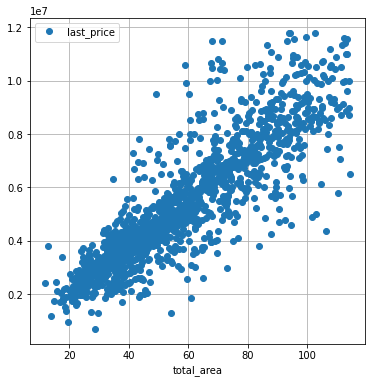

Корреляция цены и площади: 



,last_price,total_area
last_price,1.000000,0.883584
total_area,0.883584,1.000000


In [28]:
#Изучаем зависимость стоимости от общей площади
#Для этого создаем таблицу соотношение площадь/цена, её график и считаем корреляцию
(
    data.pivot_table(index='total_area', values='last_price')
    .plot(grid=True, style='o', figsize=(6, 6))
)
plt.show()
print('Корреляция цены и площади:','\n')
display(data.pivot_table(index='floor', values=['total_area', 'last_price']).corr())

Корреляция есть и довольно серьезная. Впрочем, это ясно и интуитивно - чем больше площадь, тем дороже квартира

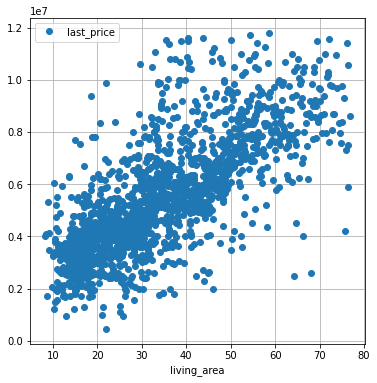

Корреляция цены и площади: 



,last_price,living_area
last_price,1.000000,0.662848
living_area,0.662848,1.000000


In [29]:
#Изучаем зависимость стоимости от жилой площади
#Для этого создаем таблицу соотношение площадь/цена, её график и считаем корреляцию
(
    data.pivot_table(index='living_area', values='last_price')
    .plot(grid=True, style='o', figsize=(6, 6))
)
plt.show()
print('Корреляция цены и площади:','\n')
display(data.pivot_table(index='floor', values=['living_area', 'last_price']).corr())

Корреляция чуть меньше, чем в предыдущем случае, но тоже довольно большая. Чем больше жилая площадь, тем дороже квартира

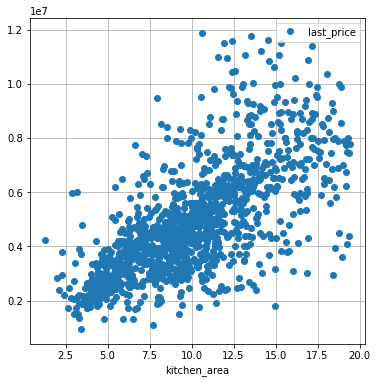

Корреляция цены и площади: 

              kitchen_area  last_price
kitchen_area      1.000000    0.556249
last_price        0.556249    1.000000 



In [30]:
#Изучаем зависимость стоимости от площади кухни
#Для этого создаем таблицу соотношение площадь/цена, её график и считаем корреляцию
(
    data.pivot_table(index='kitchen_area', values='last_price')
    .plot(grid=True, style='o', figsize=(6, 6))
)
plt.show()
print('Корреляция цены и площади:','\n')
print(data.pivot_table(index='floor', values=['kitchen_area', 'last_price']).corr(),'\n')


Также, как и в двух предыдущих параметров. Увеличение площади кухни чаще всего ведёт к увеличению стоимости квартиры.

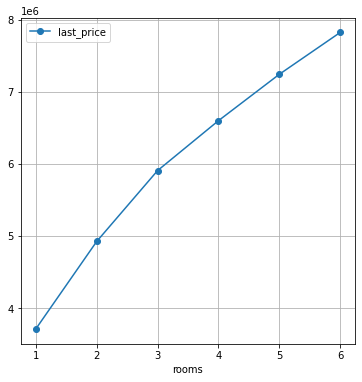

Корреляция цены и количества комнат: 



,last_price,rooms
last_price,1.000000,0.481881
rooms,0.481881,1.000000


In [31]:
#Изучаем зависимость стоимости от количества комнат
#Для этого создаем таблицу соотношение количество комнат/цена, её график и считаем корреляцию
(
    data.pivot_table(index='rooms', values='last_price')
    .plot(grid=True, style='o-', figsize=(6, 6))
)
plt.show()
print('Корреляция цены и количества комнат:', '\n')
display(data.pivot_table(index='floor', values=['rooms', 'last_price']).corr())

График довольно наглядный - чем больше комнат, тем дороже квартира. При этом, корреляция меньше, чем в соотшении с площадью квартиры. Действительно, для многих одна комната площадью 30 кв.м. лучше, чем две по 10.

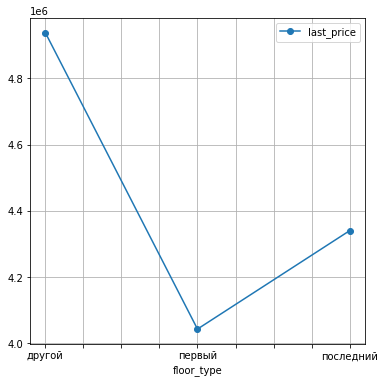

In [32]:
#Изучаем зависимость стоимости от этажа, на котором расположена квартира
#Для этого создаем таблицу соотношение этаж/цена, её график
(
    data.pivot_table(index='floor_type', values='last_price')
    .plot(grid=True, style='o-', figsize=(6, 6))
)
plt.show()

Как в песне, "первый и последний этаж не предлагать". 
Традиционно, квартиры на первом и последнем этажах считаются самыми неудобными для жизни и это отражается на их стоимости.

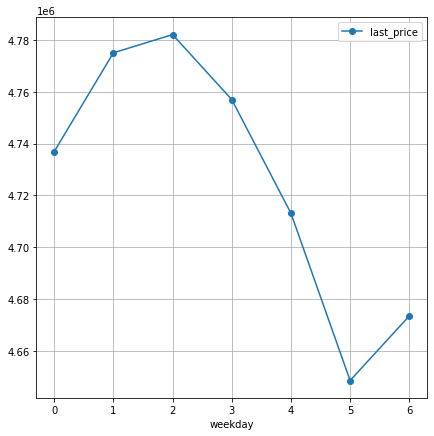

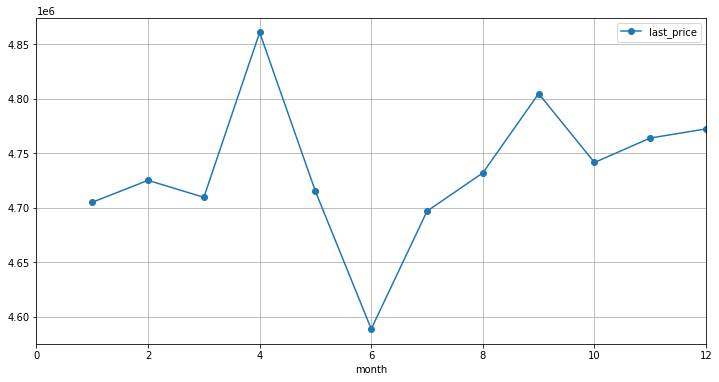

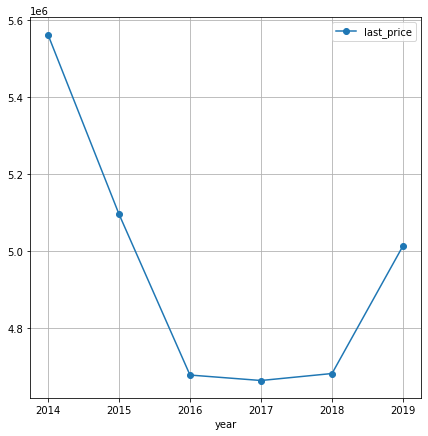

In [33]:
# Зависимость от дня размещения
(
    data.pivot_table(index='weekday', values='last_price')
    .plot(grid=True, style='o-', figsize=(7, 7))
)
plt.show()
# Зависимость от месяца размещения
(
    data.pivot_table(index='month', values='last_price')
    .plot(grid=True, style='o-', xlim=(0,12), figsize=(12, 6))
)
plt.show()
# Зависимость от года размещения
(
    data.pivot_table(index='year', values='last_price')
    .plot(grid=True, style='o-', figsize=(7, 7))
)
plt.show()

День недели: дороже всего квартиры, опубликованные в среду, дешевле всего - в субботу.
Месяц: дороже всего квартиры, продающиеся с апреля, дешевле всего - с июня.
Год: самые дорогие квартиры в среднем были в 2014 году. Но потом что-то случилось и стоимость резко упала. Продержавшись примерно на одном уровне в 2016-2018 годах, цены вновь стали расти в 2019-м

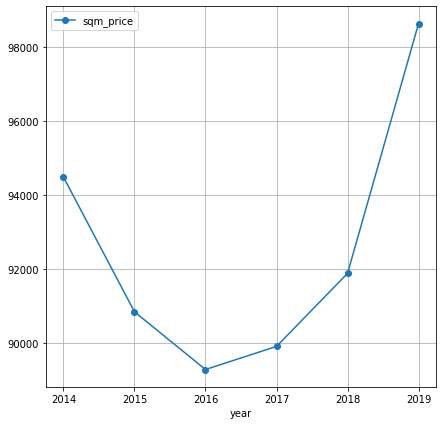

In [34]:
# Зависимость стоимости квадратного метра от года размещения
(
    data.pivot_table(index='year', values='sqm_price')
    .plot(grid=True, style='o-', figsize=(7, 7))
)
plt.show()

Интересная деталь - если общая стоимость квартиры в среднем уменьшилась в 2019-м по сравнению с 2014-м, то стоимость квадратного метра возросла. Следовательно, средняя площадь продаваемых квартир стала меньше. Это объяснимо, так как после кризисных лет люди ждут выздоровления рынка и не торопятся избавляться от серьезных активов.

**Анализ десяти населённых пунктов с наибольшим числом объявлений, анализ стоимости квадратного метра**

In [35]:
#Создаем переменную с 10 городами - лидерами по числу объявлений и переменную - таблицу со средней ценой кв.м. в этих городах
top_ten = data['locality_name'].value_counts().head(10)
top_ten_sqm_price = data.query('locality_name in (@top_ten.index)').pivot_table(values='sqm_price', index='locality_name')
top_ten_sqm_price = top_ten_sqm_price.astype(int)
top_ten_sqm_price.sort_values(by='sqm_price', ascending=False)


,sqm_price
locality_name,
Санкт-Петербург,105420
Пушкин,100047
деревня Кудрово,92943
поселок Парголово,90184
поселок Мурино,85600
поселок Шушары,78576
Колпино,75237
Гатчина,68544
Всеволожск,67000


Лидирует, ожидаемо Петербург. На втором месте Пушкин с его прекрасными парками и дворцами, далее располагаются ближайшие пригороды Петербурга, в которых можно жить, работая при этом в СПб.
Квартиры в крупных города Ленинградской области (Гатчина, Всеволожск, Выборг) заметно дешевле

**Анализ изменения цены квадратного метра в Санкт-Петербурге для каждого километра по степени удалённости от центра**

,sqm_price
city_center_nearest_km,
0.0,121139.333333
1.0,123601.678161
2.0,116349.093333
3.0,109617.961905
4.0,116663.372263
5.0,120928.547664
6.0,121944.244156
7.0,115970.421818
8.0,115949.040268


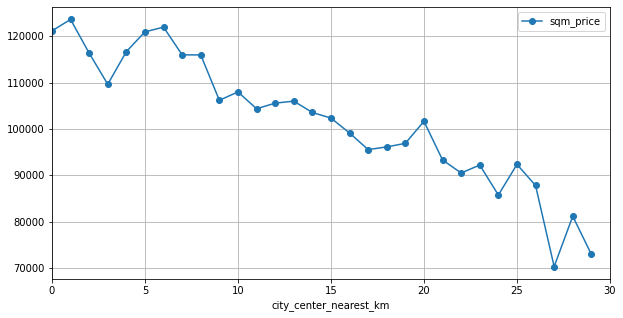

In [36]:
#Выведем на экран таблицу со средней ценой квадратного метра для каждого километра удаления от центра Петербурга 
display(data.query('locality_name == "Санкт-Петербург"')
 .pivot_table(index='city_center_nearest_km', values='sqm_price', aggfunc='mean'))
      
(data.query('locality_name == "Санкт-Петербург"')
 .pivot_table(index='city_center_nearest_km', values='sqm_price', aggfunc='mean')
 .plot(grid=True, style='o-', xlim=(0,30), figsize=(10, 5)))
plt.show()


На графике видно, что средняя цена квадратного метра снижается с отдалением от центра.  
Резкое снижение идёт на расстоянии от 7 километров - это можно считать условной границей центральных районов Петербурга.  
При этом, квартиры, находящиеся в трех километрах от центра города стоят относительно дешево - интересная деталь

**Выводы по исследовательскому анализу данных:**  
Среди факторов, влияющих на полную стоимость квартиры конечно же в первую очередь стоит упомянуть общую площадь и жилую площадь помещения. Чем больше места, тем дороже квартира в среднем. То же можно сказать и о кухне.  
Количество комнат также влияет на стоимость квартиры, но корреляция меньше.  
Квартиры на первом и последнем этаже дома стоят в среднем дешевле, чем квартиры на других этажах.
Существует корреляция между днем подачи объявления и ценой квартиры. Почему-то квартиры, которые решили продать в будний день в среднем стоят дороже, чем те, что начали продавать в выходные.  
Июнь - не самый удачный месяц для публикации объявления. Самый удачный - апрель, квартиры, которые начали продавать в этом месяце в среднем дороже всего. Возможно это связано с тем, что просмотры и финальное оформление сделки в таком случае происходит летом, любая квартира покажется красивее, когда вокруг всё цветёт.  
  
Стоимость квадратного метра, конечно, самая большая в Петербурге. Далее следует Пушкин, а за ним районы-спутники Петербурга, где можно жить, работая в центре города.  
С удалением от центра города цена за квадратный метр снижается. При этом есть интересные особенности - например на удалении в 3 километра квартиры дешевле, чем на удалении в 4,5,6,7,8. Возможно это связано, что в радиусе трех километров достаточно много домов, в которых ранее было большое количество коммунальных квартир, находящихся сейчас не в лучшем состоянии.


### Общий вывод.

В процессе исследования мы обработали полученные данные, по возможности избавились от пропусков и аномальных значений.
В данном контексте аномальными оказались квартиры, которые можно отнести к сегменту элитной недвижимости - этот сегмент требует отдельного исследования.

Наше же исследование было посвящено квартирам среднего ценового диапазано - таких в представленном датасете абсолютное большинство.

Среднее время продажи квартиры - 80 дней. Стоит признать быстрой продажу за 40 дней. Больше пяти месяцев - уже долгая продажа. 

На стоимость больше всего влияет площадь квартиры.
Размер кухни также имеет значение, как и число комнат. Но корреляция в данных случаях меньше. 
Первый этаж значительно дешевле остальных вариантов. Последний этаж стоит в среднем дороже, но тоже меньше, чем квартиры на этажах со второго до предпоследнего.  

Средняя стоимость квартир сильно упала в кризисные 2015-2017 годы, потихоньку начав расти после, но до 2019 года всё ещё не были достигнуты значения 2014 года. При этом, связано это с тем, что уменьшилась средняя площадь продаваемых квартир, ведь средняя стоимость квадратного метра в 2019-м уже выше, чем в 2014-м. 

Дороже всего квадратный метр стоит в Санкт-Петербурге и Пушкине.
Из населенных пунктов, входящих в топ-10 по числу объявлений, самый дешевый  квадратный метр в Выборге.  

В самом Петербурге стоимость квадратного метра в целом растёт при приближению квартиры к центру города.